Data import

시도 내용 요약:
주중(1)/주말(2) + 겨울(1)봄(2)여름(3)가을(4) // 

이미 lstm이라는 것이 sequence 개념이 있으므로 시간축(1~397)를 feature로 설정하는 것은 의미가 없을 듯 하여 LSTM 시도2에서는 제외함

https://bigdatascientistblog.wordpress.com/2015/10/02/feature-engineering-with-dates-part-1/

에 따르면 날짜 datestampe에서 9가지의 특성을 끌어낼 수 있다고 한다. 따라서 이를 적용해보고자 한다.

year, month, day, day of week, week of year, hour of day

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
tf.set_random_seed(7)
def MinMaxScaler(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)



In [2]:
columns=['date','amount']

txs=pd.read_table('./lstmData/lstmPrac2.csv', sep=',',header=None,names=columns )
txs.info()
txs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
date      397 non-null object
amount    397 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.3+ KB


,date,amount
0,2016-01-01,34
1,2016-01-02,41
2,2016-01-03,54
3,2016-01-04,41
4,2016-01-05,35


In [3]:
from datetime import datetime                    

# 1. 기본 feature

In [4]:
year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year  
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
# please read docs on how week numbers are calculate
week_number = lambda x: datetime.strptime(x, "%Y-%m-%d" ).strftime('%V')

# 2. 추가 feature

In [5]:
seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d" ).month-1)]

In [6]:
txs['year'] = txs['date'].map(year)
txs['month']=txs['date'].map(month)
txs['week_number']=txs['date'].map(week_number)
txs['season']=txs['date'].map(season)
txs['day_of_week']=txs['date'].map(day_of_week)
# txs['week_number']=txs['date'].map(week_number)
txs

,date,amount,year,month,week_number,season,day_of_week
0,2016-01-01,34,2016,1,53,0,4
1,2016-01-02,41,2016,1,53,0,5
2,2016-01-03,54,2016,1,53,0,6
3,2016-01-04,41,2016,1,01,0,0
4,2016-01-05,35,2016,1,01,0,1
5,2016-01-06,44,2016,1,01,0,2
6,2016-01-07,50,2016,1,01,0,3
7,2016-01-08,42,2016,1,01,0,4
8,2016-01-09,42,2016,1,01,0,5
9,2016-01-10,66,2016,1,01,0,6


pandas를 통해 구한 각 feature는 다음 코드를 통해 우리의 기준type인 list로 변경이 가능

In [7]:
list(txs['day_of_week'])

[4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,


# 3. 추가 가공

이상점 제거, normalization, bucketization 을 하여 새로운 열을 생성하는 방향으로

이상점 제거를 위해 평균과 표준편차를 구한다. 이상점의 기준은 일단 평균+-2*sd로 설정

In [8]:
np.mean(txs['amount'])

35.191435768261968

In [9]:
mean=np.mean(xy[:,-1])
mean

NameError: name 'xy' is not defined

In [ ]:
std=np.std(xy[:,-1])
std

In [ ]:
for i in range(len(xy)):
    if (xy[i,-1]<mean-2*std or xy[i,-1]>mean+2*std):
         xy[i,-1]=int(mean)
        

In [10]:
xy[:,-1]

NameError: name 'xy' is not defined

In [11]:
xy[:,-1]=MinMaxScaler(xy[:,-1])

NameError: name 'xy' is not defined

In [12]:
tempxy=[list(txs['season']),list(txs['day_of_week']),list(txs['week_number']), list(txs['amount'])]

In [13]:
tempxy

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,


In [14]:
xy=np.array(tempxy)

In [15]:
xy

array([['0', '0', '0', ..., '0', '0', '0'],
       ['4', '5', '6', ..., '6', '0', '1'],
       ['53', '53', '53', ..., '04', '05', '05'],
       ['34', '41', '54', ..., '0', '5', '31']], 
      dtype='<U21')

In [16]:
temp=xy.transpose()

In [17]:
temp

array([['0', '4', '53', '34'],
       ['0', '5', '53', '41'],
       ['0', '6', '53', '54'],
       ..., 
       ['0', '6', '04', '0'],
       ['0', '0', '05', '5'],
       ['0', '1', '05', '31']], 
      dtype='<U21')

In [18]:
xy = temp.astype(np.float)

In [19]:
xy

array([[  0.,   4.,  53.,  34.],
       [  0.,   5.,  53.,  41.],
       [  0.,   6.,  53.,  54.],
       ..., 
       [  0.,   6.,   4.,   0.],
       [  0.,   0.,   5.,   5.],
       [  0.,   1.,   5.,  31.]])

[[  0.           4.          53.           0.05964912]
 [  0.           5.          53.           0.07192982]
 [  0.           6.          53.           0.09473684]
 [  0.           0.           1.           0.07192982]
 [  0.           1.           1.           0.06140351]
 [  0.           2.           1.           0.07719298]
 [  0.           3.           1.           0.0877193 ]] -> [ 0.07368421]
[[  0.           5.          53.           0.07192982]
 [  0.           6.          53.           0.09473684]
 [  0.           0.           1.           0.07192982]
 [  0.           1.           1.           0.06140351]
 [  0.           2.           1.           0.07719298]
 [  0.           3.           1.           0.0877193 ]
 [  0.           4.           1.           0.07368421]] -> [ 0.07368421]
[[  0.           6.          53.           0.09473684]
 [  0.           0.           1.           0.07192982]
 [  0.           1.           1.           0.06140351]
 [  0.           2.          

 [ 0.          0.          5.          0.07719298]] -> [ 0.06842105]
[[ 0.          2.          4.          0.09649123]
 [ 0.          3.          4.          0.08596491]
 [ 0.          4.          4.          0.0754386 ]
 [ 0.          5.          4.          0.08596491]
 [ 0.          6.          4.          0.08596491]
 [ 0.          0.          5.          0.07719298]
 [ 0.          1.          5.          0.06842105]] -> [ 0.09122807]
[[ 0.          3.          4.          0.08596491]
 [ 0.          4.          4.          0.0754386 ]
 [ 0.          5.          4.          0.08596491]
 [ 0.          6.          4.          0.08596491]
 [ 0.          0.          5.          0.07719298]
 [ 0.          1.          5.          0.06842105]
 [ 0.          2.          5.          0.09122807]] -> [ 0.07894737]
[[ 0.          4.          4.          0.0754386 ]
 [ 0.          5.          4.          0.08596491]
 [ 0.          6.          4.          0.08596491]
 [ 0.          0.          5

[[  3.00000000e+00   5.00000000e+00   4.50000000e+01   4.21052632e-02]
 [  3.00000000e+00   6.00000000e+00   4.50000000e+01   1.40350877e-02]
 [  3.00000000e+00   0.00000000e+00   4.60000000e+01   2.63157895e-02]
 [  3.00000000e+00   1.00000000e+00   4.60000000e+01   2.98245614e-02]
 [  3.00000000e+00   2.00000000e+00   4.60000000e+01   1.57894737e-02]
 [  3.00000000e+00   3.00000000e+00   4.60000000e+01   2.98245614e-02]
 [  3.00000000e+00   4.00000000e+00   4.60000000e+01   2.28070175e-02]] -> [ 0.03333333]
[[  3.00000000e+00   6.00000000e+00   4.50000000e+01   1.40350877e-02]
 [  3.00000000e+00   0.00000000e+00   4.60000000e+01   2.63157895e-02]
 [  3.00000000e+00   1.00000000e+00   4.60000000e+01   2.98245614e-02]
 [  3.00000000e+00   2.00000000e+00   4.60000000e+01   1.57894737e-02]
 [  3.00000000e+00   3.00000000e+00   4.60000000e+01   2.98245614e-02]
 [  3.00000000e+00   4.00000000e+00   4.60000000e+01   2.28070175e-02]
 [  3.00000000e+00   5.00000000e+00   4.60000000e+01   3.33

[step: 37] loss: 1.4150654077529907
[step: 38] loss: 1.4135342836380005
[step: 39] loss: 1.4101972579956055
[step: 40] loss: 1.4055691957473755
[step: 41] loss: 1.400215744972229
[step: 42] loss: 1.394696831703186
[step: 43] loss: 1.3895279169082642
[step: 44] loss: 1.385144591331482
[step: 45] loss: 1.3818548917770386
[step: 46] loss: 1.3797972202301025
[step: 47] loss: 1.378915786743164
[step: 48] loss: 1.3789764642715454
[step: 49] loss: 1.3796213865280151
[step: 50] loss: 1.380454421043396
[step: 51] loss: 1.3811265230178833
[step: 52] loss: 1.3813986778259277
[step: 53] loss: 1.3811651468276978
[step: 54] loss: 1.380439281463623
[step: 55] loss: 1.3793163299560547
[step: 56] loss: 1.3779278993606567
[step: 57] loss: 1.3764092922210693
[step: 58] loss: 1.3748817443847656
[step: 59] loss: 1.3734484910964966
[step: 60] loss: 1.372192621231079
[step: 61] loss: 1.3711756467819214
[step: 62] loss: 1.3704266548156738
[step: 63] loss: 1.3699350357055664
[step: 64] loss: 1.3696486949920654

[step: 277] loss: 1.326170802116394
[step: 278] loss: 1.3261048793792725
[step: 279] loss: 1.3260389566421509
[step: 280] loss: 1.3259727954864502
[step: 281] loss: 1.3259068727493286
[step: 282] loss: 1.3258408308029175
[step: 283] loss: 1.3257744312286377
[step: 284] loss: 1.3257079124450684
[step: 285] loss: 1.3256415128707886
[step: 286] loss: 1.3255747556686401
[step: 287] loss: 1.3255077600479126
[step: 288] loss: 1.3254410028457642
[step: 289] loss: 1.3253737688064575
[step: 290] loss: 1.3253061771392822
[step: 291] loss: 1.3252384662628174
[step: 292] loss: 1.325170636177063
[step: 293] loss: 1.32510244846344
[step: 294] loss: 1.3250340223312378
[step: 295] loss: 1.324965238571167
[step: 296] loss: 1.3248958587646484
[step: 297] loss: 1.3248264789581299
[step: 298] loss: 1.3247565031051636
[step: 299] loss: 1.324686050415039
[step: 300] loss: 1.3246151208877563
[step: 301] loss: 1.3245437145233154
[step: 302] loss: 1.3244718313217163
[step: 303] loss: 1.324399471282959
[step: 3

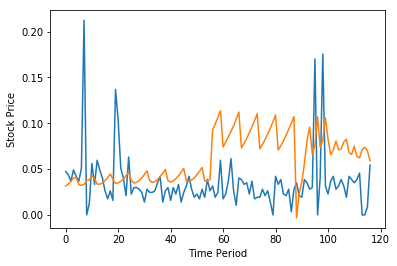

[step: 0] loss: 14.716859817504883
[step: 1] loss: 8.77663516998291
[step: 2] loss: 4.968634128570557
[step: 3] loss: 2.910391330718994
[step: 4] loss: 2.2656726837158203
[step: 5] loss: 2.6017935276031494
[step: 6] loss: 3.197444200515747
[step: 7] loss: 3.45178484916687
[step: 8] loss: 3.279803991317749
[step: 9] loss: 2.869584083557129
[step: 10] loss: 2.417206048965454
[step: 11] loss: 2.0399765968322754
[step: 12] loss: 1.7789822816848755
[step: 13] loss: 1.6270672082901
[step: 14] loss: 1.5568405389785767
[step: 15] loss: 1.5386276245117188
[step: 16] loss: 1.5479592084884644
[step: 17] loss: 1.567326307296753
[step: 18] loss: 1.5855592489242554
[step: 19] loss: 1.5964468717575073
[step: 20] loss: 1.5973317623138428
[step: 21] loss: 1.587963342666626
[step: 22] loss: 1.5696419477462769
[step: 23] loss: 1.5446031093597412
[step: 24] loss: 1.5155725479125977
[step: 25] loss: 1.4854152202606201
[step: 26] loss: 1.456841230392456
[step: 27] loss: 1.432145357131958
[step: 28] loss: 1.

[step: 235] loss: 1.3290901184082031
[step: 236] loss: 1.3290132284164429
[step: 237] loss: 1.3289374113082886
[step: 238] loss: 1.3288615942001343
[step: 239] loss: 1.3287864923477173
[step: 240] loss: 1.3287121057510376
[step: 241] loss: 1.3286380767822266
[step: 242] loss: 1.3285644054412842
[step: 243] loss: 1.3284912109375
[step: 244] loss: 1.3284183740615845
[step: 245] loss: 1.3283458948135376
[step: 246] loss: 1.3282735347747803
[step: 247] loss: 1.3282021284103394
[step: 248] loss: 1.3281313180923462
[step: 249] loss: 1.328060269355774
[step: 250] loss: 1.3279900550842285
[step: 251] loss: 1.327919602394104
[step: 252] loss: 1.3278499841690063
[step: 253] loss: 1.3277802467346191
[step: 254] loss: 1.3277111053466797
[step: 255] loss: 1.3276419639587402
[step: 256] loss: 1.3275734186172485
[step: 257] loss: 1.3275052309036255
[step: 258] loss: 1.3274366855621338
[step: 259] loss: 1.3273688554763794
[step: 260] loss: 1.327301263809204
[step: 261] loss: 1.3272335529327393
[step: 

[step: 472] loss: 1.2815665006637573
[step: 473] loss: 1.2810068130493164
[step: 474] loss: 1.2804440259933472
[step: 475] loss: 1.2798784971237183
[step: 476] loss: 1.2793108224868774
[step: 477] loss: 1.2787418365478516
[step: 478] loss: 1.2781708240509033
[step: 479] loss: 1.2775990962982178
[step: 480] loss: 1.2770264148712158
[step: 481] loss: 1.276453971862793
[step: 482] loss: 1.2758815288543701
[step: 483] loss: 1.2753100395202637
[step: 484] loss: 1.2747411727905273
[step: 485] loss: 1.2741833925247192
[step: 486] loss: 1.2736796140670776
[step: 487] loss: 1.2734687328338623
[step: 488] loss: 1.2748395204544067
[step: 489] loss: 1.2849550247192383
[step: 490] loss: 1.3163155317306519
[step: 491] loss: 1.3528027534484863
[step: 492] loss: 1.2799632549285889
[step: 493] loss: 1.3019263744354248
[step: 494] loss: 1.3104782104492188
[step: 495] loss: 1.275726318359375
[step: 496] loss: 1.3114410638809204
[step: 497] loss: 1.270766258239746
[step: 498] loss: 1.30050790309906
[step:

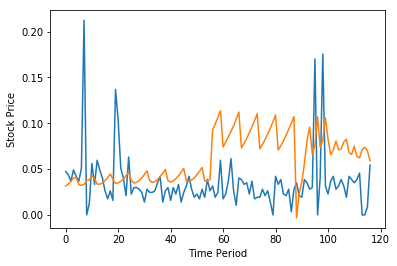

In [20]:
#train parameters
seq_length=7
data_dim=4
hidden_dim=10
output_dim=1
learning_rate=0.01
iterations=500
#기본형식
#기본 인자로는 ds-y로 받고 
#처리함수에서 ds를 받아서 'feature 처리모듈'에서 ds에서 요일(주중, 주말), 월(계절) + 날씨와 같은 추가 요인-값을 받는다.
xy[:,3]=MinMaxScaler(xy[:,3])

x=xy
y=xy[:,[-1]]

#build a dataset
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length):
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]
    print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)

# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

#input place holders
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, 1])
# build a LSTM network(input: cell shape, type/ )
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# use the last cell's output to calculate Y_pred
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=tf.tanh) 
# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()
